### Imports
>- I imported pandas, numpy and matplotlib for data manipulation and visualization.
>- h5py is used for loading in h5 files, which is the format used by the eye gaze dataset
>- Sklearn is used for the machine learning algorithms

In [32]:
import pandas as pd
import os
import json
import matplotlib.pyplot as plt
import h5py
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.neighbors import KNeighborsRegressor
import time

from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPool2D
from tensorflow.keras.models import Sequential
#import adaptave linear regressor
from sklearn.svm import SVR

#### Data pre-processing

In [33]:
# The synthetic file is a .h5 file that contains the data for the computer generated eye tracking data
synthetic_file = h5py.File('../EyeGaze/archive/gaze.h5','r')
look_vec = pd.DataFrame(synthetic_file['look_vec'])
print(synthetic_file.keys())
print(str(len(synthetic_file['image'])) + ' images')

<KeysViewHDF5 ['image', 'look_vec', 'path']>
50000 images


In [34]:
# We now zip the image data into a single dataframe, we get image width and height for those images
for _, (ikey, ival) in zip(range(1), synthetic_file['image'].items()):
    print('Images dimentions: ',ival.shape)
    img_width, img_height = ival.shape

Images dimentions:  (35, 55)


In [35]:
# this syn_images is all 50000 synthetic images in a single dataframe
syn_images = np.stack([a for a in synthetic_file['image'].values()])

In [36]:
# we have now read in all data we need from the synthetic data file, we close it
synthetic_file.close()

In [37]:
# rename look vector columns to x and y
look_vec.drop(3, axis=1, inplace=True)
look_vec.columns = ['x','y','z']
look_vec

,x,y,z
0,0.6431,-0.1524,-0.7504
1,0.2652,-0.2683,-0.9261
2,0.1989,0.2961,-0.9342
3,0.1647,-0.5925,-0.7885
4,-0.0701,0.1484,-0.9864
...,...,...,...
49995,0.0862,-0.3538,-0.9313
49996,0.4509,-0.0815,-0.8889
49997,-0.5688,0.3151,-0.7597
49998,0.6765,-0.3712,-0.6360


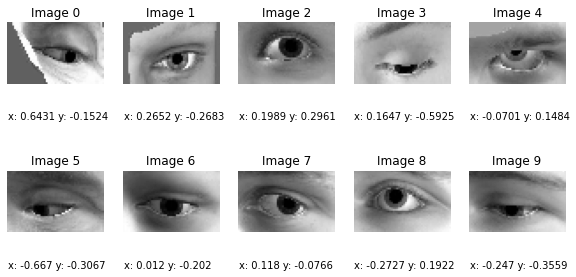

In [38]:
# graph showing 10 random images, showing their gaze vectors so we get a better understand of what they mean
plt.figure(figsize=(10,5))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(syn_images[i], cmap='gray')
    plt.title('Image ' + str(i))
    plt.text(0,img_height, 'x: ' + str(look_vec['x'][i]) + ' y: ' + str(look_vec['y'][i]))
    plt.axis('off')

#### Building some models

In [39]:
# we now have a dataframe with all the gaze vectors and images, we can now split the data into training and testing data with test size of 0.2
feature_train, feature_test, target_train, target_test = train_test_split(syn_images/255.0, look_vec[['x','y']], test_size = 0.2)

In [40]:
modelsDict = {'RF' : RandomForestRegressor(), 'KNN' : KNeighborsRegressor()}

RF MSE: 
x    0.361002
y    0.216429
dtype: float64


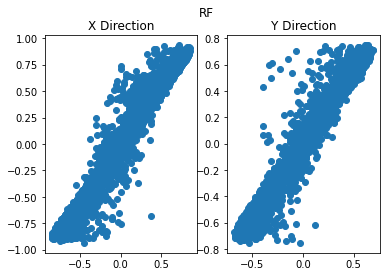

KNN MSE: 
x    0.354601
y    0.221250
dtype: float64


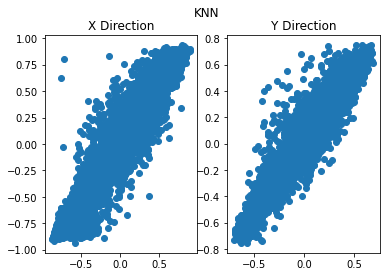

In [72]:
# track how much time it takes to train each model
train_times = {}
for modelName, model in modelsDict.items():
    start = time.time()
    # train the models
    pipe = Pipeline([('flatten', FunctionTransformer(lambda x: x.reshape(x.shape[0], -1), 
                                                        validate = False)), 
                        (modelName, model)])
    pipe.fit(feature_train[::4], target_train[::4])
    target_pred = pd.DataFrame(pipe.predict(feature_test), columns=['x','y'])

    # calculate the error
    mse = np.mean((target_pred - target_test)**2)
    print(modelName + ' MSE: \n' + str(mse))

    # calculate the time it took to train
    train_times[modelName] = time.time() - start

    # create a graph comparing the predicted gaze vectors to the actual gaze vectors
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.scatter(target_pred['x'], target_test['x'])
    ax1.set_title('X Direction')
    ax2.scatter(target_pred['y'], target_test['y'])
    ax2.set_title('Y Direction')
    fig.suptitle(modelName)
    plt.show()


In [61]:
# create a CNN model with basic layers
cnn = Sequential()
cnn.add(Conv2D(kernel_size =(3,3), input_shape = feature_train.shape[1:], filters = 32, activation = 'relu'))
cnn.add(MaxPool2D(pool_size = (2,2)))
cnn.add(Conv2D(kernel_size =(3,3), filters = 64, activation = 'relu'))
cnn.add(MaxPool2D(pool_size = (2,2)))
cnn.add(Flatten())
cnn.add(Dense(units = 128, activation = 'relu'))
cnn.add(Dense(units = 2, activation = 'tanh'))
cnn.compile('sgd', 'mse')                                                                                                                                                                                                                                                         

In [62]:
feature_train.shape[1:]+(1,)

(35, 55, 1, 1)

In [63]:
feature_train.shape

(40000, 35, 55, 1)

In [64]:
np.expand_dims(feature_train, -1).shape

(40000, 35, 55, 1, 1)

In [66]:
start = time.time()
# train the model
cnn.fit(np.expand_dims(feature_train, -1), target_train, epochs = 10)
# calculate the time it took to train
train_times['CNN'] = time.time() - start

Epoch 1/10
1250/1250 [==============================] - 48s 39ms/step - loss: 0.0136
Epoch 2/10
1250/1250 [==============================] - 58s 47ms/step - loss: 0.0113
Epoch 3/10
1250/1250 [==============================] - 52s 42ms/step - loss: 0.0099
Epoch 4/10
1250/1250 [==============================] - 51s 41ms/step - loss: 0.0088
Epoch 5/10
1250/1250 [==============================] - 52s 41ms/step - loss: 0.0080
Epoch 6/10
1250/1250 [==============================] - 53s 43ms/step - loss: 0.0073
Epoch 7/10
1250/1250 [==============================] - 53s 42ms/step - loss: 0.0067
Epoch 8/10
1250/1250 [==============================] - 52s 42ms/step - loss: 0.0063
Epoch 9/10
1250/1250 [==============================] - 53s 43ms/step - loss: 0.0058
Epoch 10/10
1250/1250 [==============================] - 58s 46ms/step - loss: 0.0055


In [68]:
# make y_pred a dataframe with same format of y_test
target_pred_cnn = pd.DataFrame(cnn.predict(np.expand_dims(feature_test, -1)), columns=['x','y'])

CNN MSE: 
x    0.376124
y    0.225803
dtype: float64


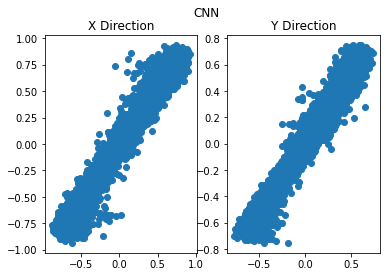

In [76]:
mse = np.mean((target_pred_cnn - target_test)**2)
print("CNN MSE: \n" + str(mse))
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.scatter(target_pred_cnn['x'], target_test['x'])
ax1.set_title('X Direction')
ax2.scatter(target_pred_cnn['y'], target_test['y'])
ax2.set_title('Y Direction')
fig.suptitle('CNN')
plt.show()

Text(0, 0.5, 'Time (s)')

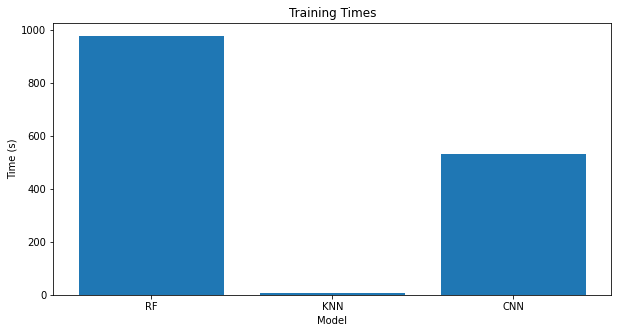

In [88]:
# graph comparing times to train each model
plt.figure(figsize=(10,5))
plt.bar(train_times.keys(), train_times.values())
plt.title('Training Times')
plt.xlabel('Model')
plt.ylabel('Time (s)')

In [81]:
train_times

{'RF': 977.6099078655243, 'KNN': 6.894593000411987, 'CNN': 531.8}

In [101]:
target_test

,x,y
6332,-0.4494,0.5905
35283,0.2343,0.3897
37416,-0.0115,-0.2896
27366,-0.6109,0.0386
17473,-0.0611,0.6513
...,...,...
42167,-0.6876,0.3220
4462,0.0065,0.6668
20200,-0.0015,0.0865
19515,-0.2732,-0.1856


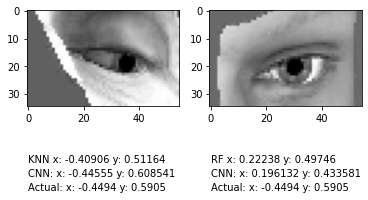

In [104]:
# show images with their predicted gaze vectors, rounding to the closest 6 decimals
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(syn_images[0], cmap='gray')
ax1.text(0,img_height, 'KNN x: ' + str(round(target_pred['x'][0],6)) + ' y: ' + str(round(target_pred['y'][0],6)))
ax1.text(0,img_height+5, 'CNN: x: ' + str(round(target_pred_cnn['x'][0],6)) + ' y: ' + str(round(target_pred_cnn['y'][0],6)))
ax1.text(0,img_height+10, 'Actual: x: ' + str(round(target_test['x'][target_test.index[0]],6)) + ' y: ' + str(round(target_test['y'][target_test.index[0]],6)))
ax2.imshow(syn_images[1], cmap='gray')
ax2.text(0,img_height, 'RF x: ' + str(round(target_pred['x'][1],6)) + ' y: ' + str(round(target_pred['y'][1],6)))
ax2.text(0,img_height+5, 'CNN: x: ' + str(round(target_pred_cnn['x'][1],6)) + ' y: ' + str(round(target_pred_cnn['y'][1],6)))
ax2.text(0,img_height+10, 'Actual: x: ' + str(round(target_test['x'][target_test.index[0]],6)) + ' y: ' + str(round(target_test['y'][target_test.index[0]],6)))
plt.show()